# Importing Libraries

In [62]:
# Data manipulation and numerical computing
import pandas as pd
import numpy as np

# Visualization libraries for EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering (used for creating location-based features)
from sklearn.cluster import KMeans

# Preprocessing utilities
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Machine learning model
import xgboost as xgb

# Model evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV


# Load the dataset

In [30]:
# Load the dataset
df = pd.read_csv('/content/AB_NYC_2019.csv')

## Load and Initial Data Overview

In [32]:
# Display the first few rows to get an initial sense of data structure and values
print("DataFrame Head:")
print(df.head())

# Print dataset metadata
print("\nDataFrame Info:")
df.info()

# Generate descriptive statistics for both numeric and categorical columns
print("\nDescriptive Statistics:")
print(df.describe(include='all'))


DataFrame Head:
     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1       

## Data Cleaning

In [34]:
print(f"Original DataFrame shape: {df.shape}")

#  Filter rows where 'price' is less than or equal to 0 or greater than 1000
df = df[(df['price'] > 0) & (df['price'] <= 1000)]
print(f"DataFrame shape after price filtering: {df.shape}")

#  Create a new target variable 'log_price' by applying np.log1p to the 'price' column
df['log_price'] = np.log1p(df['price'])
print("Created 'log_price' column.")

#  Drop specified noise columns
columns_to_drop = ['id', 'name', 'host_name', 'last_review']
df = df.drop(columns=columns_to_drop)
print(f"Dropped columns: {', '.join(columns_to_drop)}.")

#  Print the head of the cleaned DataFrame
print("\nHead of the cleaned DataFrame:")
print(df.head())

Original DataFrame shape: (48895, 16)
DataFrame shape after price filtering: (48645, 16)
Created 'log_price' column.
Dropped columns: id, name, host_name, last_review.

Head of the cleaned DataFrame:
   host_id neighbourhood_group neighbourhood  latitude  longitude  \
0     2787            Brooklyn    Kensington  40.64749  -73.97237   
1     2845           Manhattan       Midtown  40.75362  -73.98377   
2     4632           Manhattan        Harlem  40.80902  -73.94190   
3     4869            Brooklyn  Clinton Hill  40.68514  -73.95976   
4     7192           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews  \
0     Private room    149               1                  9   
1  Entire home/apt    225               1                 45   
2     Private room    150               3                  0   
3  Entire home/apt     89               1                270   
4  Entire home/apt     80              10                  9   



The data cleaning process involved several crucial steps to prepare the dataset for modeling:

-   **Price Filtering (`df = df[(df['price'] > 0) & (df['price'] <= 1000)]`)**:
    -   **Rationale**: The initial `df.describe()` output showed a maximum price of 10000, indicating potential outliers that could skew model training. Filtering out prices less than or equal to 0 (erroneous entries) and greater than 1000 helps to focus on a more realistic and common range of Airbnb prices, improving model robustness and reducing the impact of extreme values.
    -   **Impact**: This step removed a small number of rows (from 48895 to 48645), resulting in a more refined dataset for price prediction, primarily addressing extreme price values.

-   **Log Transformation of Price (`df['log_price'] = np.log1p(df['price'])`)**:
    -   **Rationale**: Price distributions are often right-skewed, which can negatively impact the performance of linear models or models sensitive to the scale of the target variable. Applying `np.log1p` (log(1+x)) transforms the target variable `price` into a more normally distributed form, making it suitable for regression models. The `+1` ensures that zero prices (if any existed after filtering) are handled gracefully without resulting in negative infinity.
    -   **Impact**: A new column `log_price` was created, which will serve as the target variable for the machine learning model. This transformation helps the model capture relationships more effectively and often leads to better predictive performance.

-   **Dropping Noise Columns (`columns_to_drop = ['id', 'name', 'host_name', 'last_review']`)**:
    -   **Rationale**: These columns are considered 'noise' for price prediction:
        -   `id`: A unique identifier with no predictive power.
        -   `name`: Free-text descriptions are complex to process and often do not directly contribute to a numeric price prediction in a straightforward manner without advanced NLP.
        -   `host_name`: While a host's reputation might influence price, the name itself is not a direct predictor and might introduce high cardinality issues or privacy concerns. `host_id` is more appropriate for host-related features.
        -   `last_review`: A date column that might have some temporal relationship, but without further feature engineering (e.g., 'days since last review'), it's not directly usable and contains many missing values.
    -   **Impact**: Removing these columns reduces the dimensionality of the dataset, simplifies the model, removes irrelevant or hard-to-process features, and potentially mitigates issues like high cardinality and privacy concerns. This makes the dataset cleaner and more focused on relevant predictive features.

## Exploratory Data Analysis (EDA)

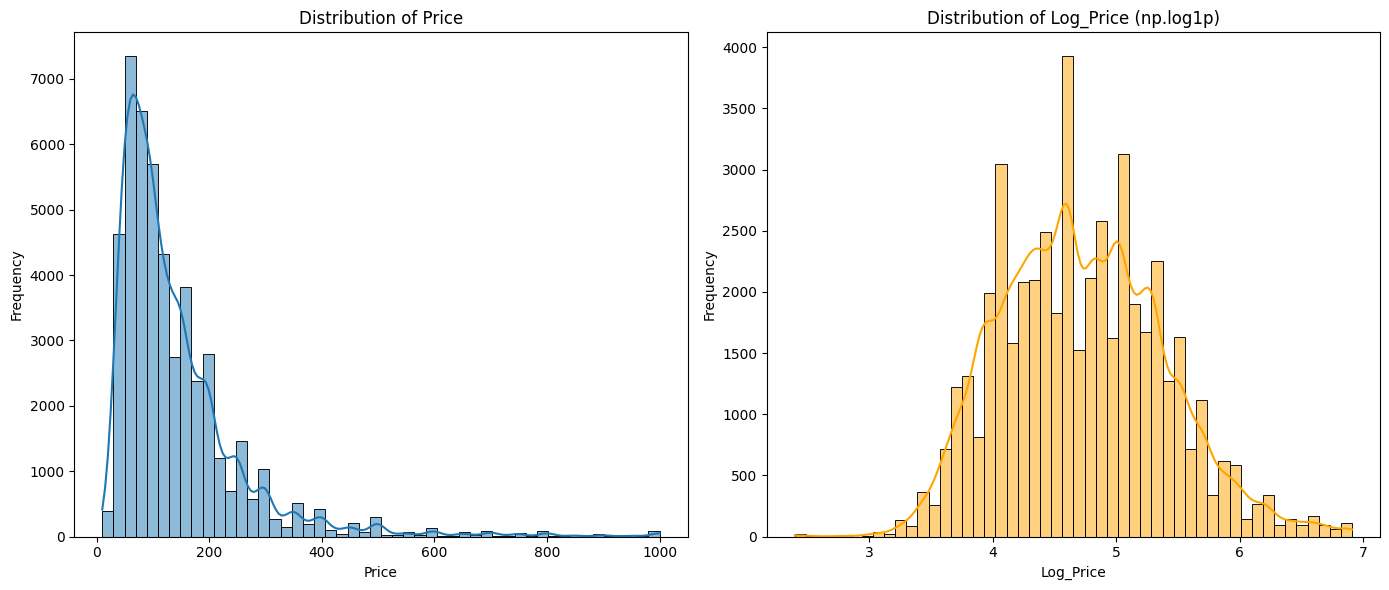

In [37]:
# Plot the distributions of raw price vs. log-transformed price
plt.figure(figsize=(14, 6))

# Original price distribution — typically right-skewed
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Log-transformed price — should appear more normalized and symmetric
plt.subplot(1, 2, 2)
sns.histplot(df['log_price'], bins=50, kde=True, color='orange')
plt.title('Distribution of Log_Price (np.log1p)')
plt.xlabel('Log_Price')
plt.ylabel('Frequency')

# Adjust layout for cleaner visual spacing
plt.tight_layout()
plt.show()

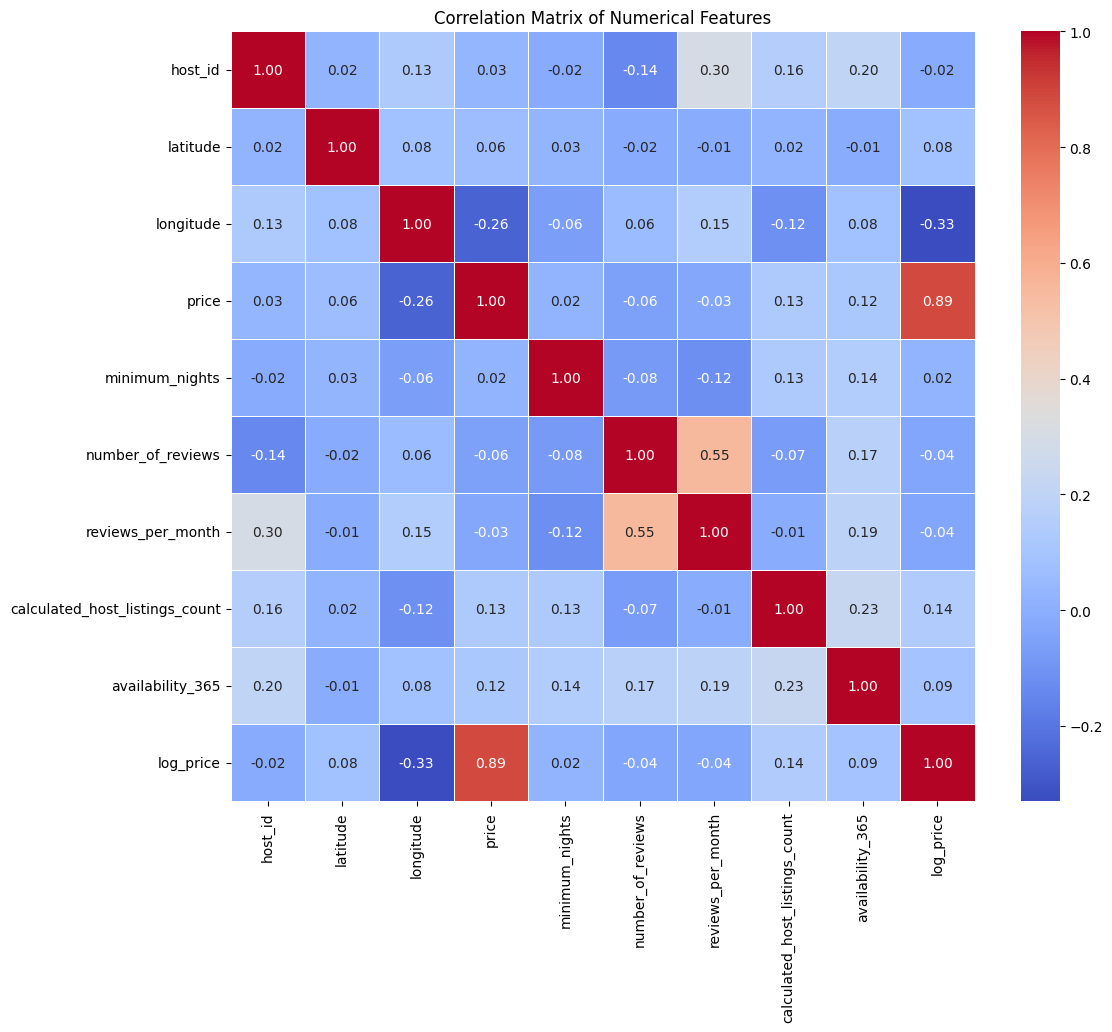

In [38]:
# Compute and visualize the correlation matrix for all numerical features
plt.figure(figsize=(12, 10))

# Select only numeric columns for correlation calculation
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Compute pairwise correlations
corr_matrix = df[numerical_cols].corr()

# Heatmap showing strength/direction of relationships between numeric variables
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=.5
)

# Add a descriptive title for readability
plt.title('Correlation Matrix of Numerical Features')

# Display the heatmap
plt.show()

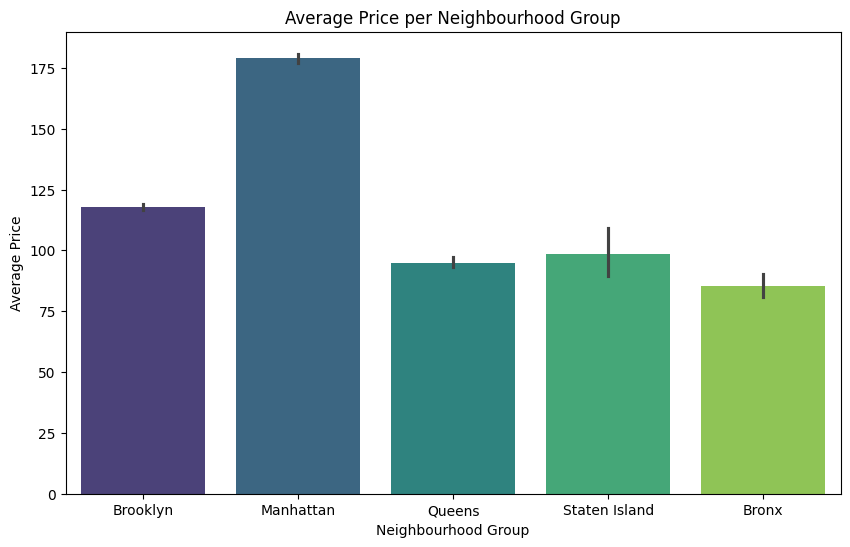

In [39]:
# Visualize the average price across each neighbourhood group
plt.figure(figsize=(10, 6))

# Bar plot showing mean price for each neighbourhood group
sns.barplot(
    x='neighbourhood_group',
    y='price',
    data=df,
    estimator=np.mean,
    palette='viridis',
    hue='neighbourhood_group',
    legend=False
)

# Add clear axis labels and title for interpretation
plt.title('Average Price per Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price')

# Display the bar plot
plt.show()

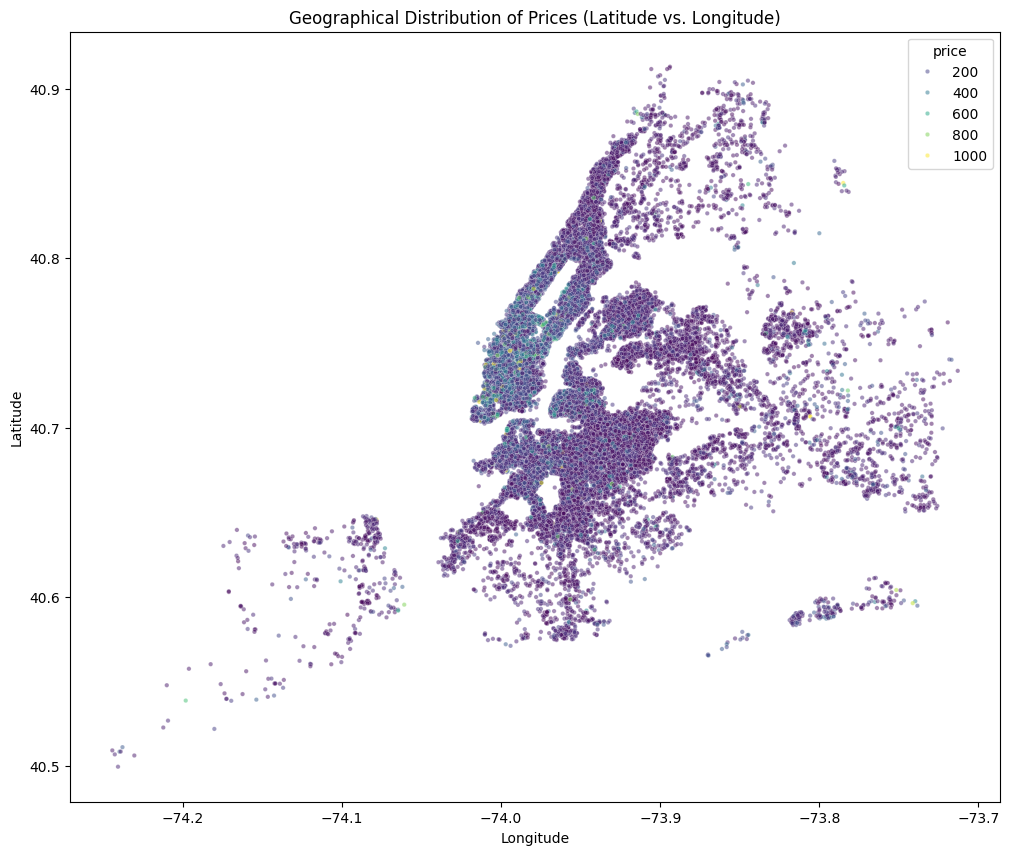

In [40]:
# Visualize geographical distribution of listings colored by price level
plt.figure(figsize=(12, 10))

# Scatter plot showing NYC listings on a latitude–longitude map
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='price',
    data=df,
    s=10,
    alpha=0.5,
    palette='viridis'
)

# Add descriptive labels and title for geographic interpretation
plt.title('Geographical Distribution of Prices (Latitude vs. Longitude)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the scatter plot
plt.show()

# The Exploratory Data Analysis (EDA) provided several key insights into the Airbnb dataset:

-   **Distribution of Price and Log_Price**:
    -   The `Distribution of Price` plot (`sns.histplot(df['price'])`) clearly showed a highly right-skewed distribution, with a large concentration of listings at lower prices and a long tail extending towards higher prices. This type of distribution is common for real-world price data and indicates the presence of outliers or high-value properties that can significantly affect model training if not handled. The majority of listings are under $200.
    -   The `Distribution of Log_Price` plot (`sns.histplot(df['log_price'])`) demonstrated the effectiveness of the `np.log1p` transformation. The `log_price` distribution is much closer to a normal (Gaussian) distribution, with its values spread more evenly across the range. This transformation is crucial for many regression models, as it helps satisfy assumptions of normality and linearity, leading to more robust and better-performing models.

-   **Correlation Matrix of Numerical Features**:
    -   The heatmap revealed the relationships between numerical features. Key observations include:
        -   `price` and `log_price` are, as expected, very highly correlated (almost 1.0), which confirms that `log_price` is a direct transformation of `price`.
        -   `number_of_reviews` and `reviews_per_month` show a strong positive correlation, which makes sense as more reviews generally imply more activity over time.
        -   `price` and `log_price` show a weak positive correlation with `latitude`, suggesting a slight tendency for prices to increase as latitude increases within NYC, but this is not a strong driver.
        -   `price` and `log_price` show a moderate negative correlation with `longitude`, indicating that listings further west (lower longitude, e.g., closer to the Hudson River or specific Manhattan areas) tend to have higher prices. This aligns with geographical expectations in NYC.
        -   `minimum_nights` generally has a very weak correlation with price, suggesting that the minimum stay requirement might not be a major direct predictor of price within the cleaned range.
        -   `availability_365` also shows a weak correlation, meaning how often a listing is available throughout the year doesn't strongly dictate its price.

-   **Average Price per Neighbourhood Group**:
    -   The bar plot `Average Price per Neighbourhood Group` highlighted significant variations in average prices across different boroughs. Manhattan consistently shows the highest average price, significantly exceeding other neighbourhood groups. Brooklyn follows, with Staten Island, Queens, and The Bronx having considerably lower average prices. This confirms that location at a high level (borough) is a very strong determinant of Airbnb prices in NYC.

-   **Geographical Distribution of Prices (Latitude vs. Longitude)**:
    -   The scatter plot `Geographical Distribution of Prices` visualizes the spatial distribution of prices across NYC. It clearly shows clusters of higher-priced listings (represented by yellow/lighter colors in the 'viridis' colormap) primarily in Manhattan, particularly in the central and downtown areas. Brooklyn also shows some areas with moderate to higher prices. This visual confirms that specific geographical pockets, especially in desirable areas of Manhattan, command premium prices, even within the filtered price range. This strongly suggests that geographical coordinates (`latitude`, `longitude`) are important features for price prediction.

## Feature Engineering

In [41]:
print(f"DataFrame shape before feature engineering: {df.shape}")

#  Calculate the average 'price' for each unique 'neighbourhood' and create 'neighborhood_average_price'
neighborhood_avg_price = df.groupby('neighbourhood')['price'].mean().rename('neighborhood_average_price')
df = df.merge(neighborhood_avg_price, on='neighbourhood', how='left')
print("Created 'neighborhood_average_price' feature.")

print("Head of DataFrame with 'neighborhood_average_price':")
print(df[['neighbourhood', 'price', 'neighborhood_average_price']].head())

DataFrame shape before feature engineering: (48645, 13)
Created 'neighborhood_average_price' feature.
Head of DataFrame with 'neighborhood_average_price':
  neighbourhood  price  neighborhood_average_price
0    Kensington    149                   92.885714
1       Midtown    225                  265.693316
2        Harlem    150                  114.034301
3  Clinton Hill     89                  149.460457
4   East Harlem     80                  120.560647


In [44]:
#  Use KMeans clustering on 'latitude' and 'longitude' to create a 'location_cluster' feature
location_data = df[['latitude', 'longitude']]

# Instantiate KMeans with a suitable number of clusters (e.g., 8) and random_state for reproducibility
kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')

# Fit KMeans to the location data and get cluster labels
df['location_cluster'] = kmeans.fit_predict(location_data)

print("Created 'location_cluster' feature using KMeans.")

print("Head of DataFrame with 'location_cluster':")
print(df[['latitude', 'longitude', 'location_cluster']].head())

Created 'location_cluster' feature using KMeans.
Head of DataFrame with 'location_cluster':
   latitude  longitude  location_cluster
0  40.64749  -73.97237                 0
1  40.75362  -73.98377                 6
2  40.80902  -73.94190                 1
3  40.68514  -73.95976                 5
4  40.79851  -73.94399                 1


In [45]:
print(f"DataFrame shape before adding additional features: {df.shape}")

#  Handle missing values in 'reviews_per_month' and create 'has_reviews'
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['has_reviews'] = (df['reviews_per_month'] > 0).astype(int)
print("Handled missing 'reviews_per_month' and created 'has_reviews' feature.")

#  Create a new categorical feature 'stay_category' from 'minimum_nights'
bins = [0, 2, 7, df['minimum_nights'].max()]
labels = ['short_stay', 'medium_stay', 'long_stay']
df['stay_category'] = pd.cut(df['minimum_nights'], bins=bins, labels=labels, right=True, include_lowest=True)
print("Created 'stay_category' feature.")

#  Print the head of the DataFrame to display the newly engineered features
print("\nHead of DataFrame with newly engineered features:")
print(df[['reviews_per_month', 'has_reviews', 'minimum_nights', 'stay_category', 'location_cluster', 'neighborhood_average_price']].head())

DataFrame shape before adding additional features: (48645, 15)
Handled missing 'reviews_per_month' and created 'has_reviews' feature.
Created 'stay_category' feature.

Head of DataFrame with newly engineered features:
   reviews_per_month  has_reviews  minimum_nights stay_category  \
0               0.21            1               1    short_stay   
1               0.38            1               1    short_stay   
2               0.00            0               3   medium_stay   
3               4.64            1               1    short_stay   
4               0.10            1              10     long_stay   

   location_cluster  neighborhood_average_price  
0                 0                   92.885714  
1                 6                  265.693316  
2                 1                  114.034301  
3                 5                  149.460457  
4                 1                  120.560647  


The feature engineering step involved creating several new features to enhance the predictive power of the model:

-   **`neighborhood_average_price`**: This feature was created by calculating the mean `price` for each unique `neighbourhood` and then mapping these averages back to the DataFrame. This helps to capture the general price level of a specific area, which is a strong indicator of listing value due to factors like desirability, amenities, and location prestige. It provides a more granular geographical price indicator than `neighbourhood_group`.

-   **`location_cluster`**: Using `KMeans` clustering on the `latitude` and `longitude` coordinates, listings were grouped into 8 distinct geographical clusters. This categorical feature segments the city into areas with similar spatial characteristics, potentially identifying micro-neighborhoods or regions that influence pricing differently. It allows the model to learn patterns based on a listing's precise location beyond just the `neighbourhood` or `neighbourhood_group`.

-   **`has_reviews`**: This binary feature (0 or 1) indicates whether a listing has any reviews (`reviews_per_month > 0`). Before creating this, missing values in `reviews_per_month` (which typically mean no reviews) were filled with 0. The presence or absence of reviews can be an indicator of a listing's activity, popularity, or maturity, which might indirectly correlate with price or booking confidence.

-   **`stay_category`**: Derived from `minimum_nights`, this categorical feature classifies listings into 'short_stay' (1-2 nights), 'medium_stay' (3-7 nights), and 'long_stay' (>7 nights). This helps the model understand different market segments for rentals. For instance, short-term stays might command higher nightly rates, while longer stays might offer discounts, and this feature allows the model to capture such patterns.

## Preprocessing

In [48]:
print(f"DataFrame shape before separating features and target: {df.shape}")

#  Separate features (X) and target (y)
y = df['log_price']
X = df.drop(columns=['price', 'log_price'])
print(f"X shape: {X.shape}, y shape: {y.shape}")

#  Identify numeric and categorical columns within X
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print(f"\nIdentified {len(numeric_cols)} numeric columns: {numeric_cols}")
print(f"Identified {len(categorical_cols)} categorical columns: {categorical_cols}")

print("First 5 rows of X:")
print(X.head())

DataFrame shape before separating features and target: (48645, 17)
X shape: (48645, 15), y shape: (48645,)

Identified 11 numeric columns: ['host_id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighborhood_average_price', 'location_cluster', 'has_reviews']
Identified 3 categorical columns: ['neighbourhood_group', 'neighbourhood', 'room_type']
First 5 rows of X:
   host_id neighbourhood_group neighbourhood  latitude  longitude  \
0     2787            Brooklyn    Kensington  40.64749  -73.97237   
1     2845           Manhattan       Midtown  40.75362  -73.98377   
2     4632           Manhattan        Harlem  40.80902  -73.94190   
3     4869            Brooklyn  Clinton Hill  40.68514  -73.95976   
4     7192           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  minimum_nights  number_of_reviews  reviews_per_month  \
0     Private room               1             

In [49]:
print(f"X shape before imputation: {X.shape}")

# Re-identify numeric and categorical columns within X, including 'category' dtype
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nRe-identified {len(numeric_cols)} numeric columns: {numeric_cols}")
print(f"Re-identified {len(categorical_cols)} categorical columns: {categorical_cols}")

#  Initialize SimpleImputer for numeric and categorical features
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Apply median imputation to numeric columns
X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])
print("Applied median imputation to numeric columns.")

# Apply most frequent imputation to categorical columns
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])
print("Applied most frequent imputation to categorical columns.")

print("\nChecking for missing values after imputation:")
print(X.isnull().sum().sum())
print("\nFirst 5 rows of X after imputation:")
print(X.head())

X shape before imputation: (48645, 15)

Re-identified 11 numeric columns: ['host_id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighborhood_average_price', 'location_cluster', 'has_reviews']
Re-identified 4 categorical columns: ['neighbourhood_group', 'neighbourhood', 'room_type', 'stay_category']
Applied median imputation to numeric columns.
Applied most frequent imputation to categorical columns.

Checking for missing values after imputation:
0

First 5 rows of X after imputation:
   host_id neighbourhood_group neighbourhood  latitude  longitude  \
0   2787.0            Brooklyn    Kensington  40.64749  -73.97237   
1   2845.0           Manhattan       Midtown  40.75362  -73.98377   
2   4632.0           Manhattan        Harlem  40.80902  -73.94190   
3   4869.0            Brooklyn  Clinton Hill  40.68514  -73.95976   
4   7192.0           Manhattan   East Harlem  40.79851  -73.94399   

In [50]:
print(f"X shape before one-hot encoding: {X.shape}")

#  Initialize OneHotEncoder
# handle_unknown='ignore' will encode previously unseen categories as all zeros
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Apply one-hot encoding to categorical columns
X_encoded = ohe.fit_transform(X[categorical_cols])

# Create a DataFrame from the one-hot encoded features with proper column names
encoded_col_names = ohe.get_feature_names_out(categorical_cols)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_col_names, index=X.index)
print(f"Shape of one-hot encoded features: {X_encoded_df.shape}")

# Concatenate numeric columns with the one-hot encoded categorical columns
X_preprocessed = pd.concat([X[numeric_cols], X_encoded_df], axis=1)

print("Applied one-hot encoding to categorical columns and concatenated with numeric columns.")
print(f"Final preprocessed X shape: {X_preprocessed.shape}")
print("\nFirst 5 rows of X_preprocessed after one-hot encoding:")
print(X_preprocessed.head())

X shape before one-hot encoding: (48645, 15)
Shape of one-hot encoded features: (48645, 232)
Applied one-hot encoding to categorical columns and concatenated with numeric columns.
Final preprocessed X shape: (48645, 243)

First 5 rows of X_preprocessed after one-hot encoding:
   host_id  latitude  longitude  minimum_nights  number_of_reviews  \
0   2787.0  40.64749  -73.97237             1.0                9.0   
1   2845.0  40.75362  -73.98377             1.0               45.0   
2   4632.0  40.80902  -73.94190             3.0                0.0   
3   4869.0  40.68514  -73.95976             1.0              270.0   
4   7192.0  40.79851  -73.94399            10.0                9.0   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                             6.0             365.0   
1               0.38                             2.0             355.0   
2               0.00                             1.0             365.0   
3     

In [51]:
print(f"Shape of X_preprocessed before split: {X_preprocessed.shape}")
print(f"Shape of y before split: {y.shape}")

#  Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_preprocessed before split: (48645, 243)
Shape of y before split: (48645,)

Shape of X_train: (38916, 243)
Shape of X_test: (9729, 243)
Shape of y_train: (38916,)
Shape of y_test: (9729,)


# The preprocessing phase was critical to transform the raw and engineered features into a format suitable for machine learning models:

-   **Separating Features and Target (`X`, `y`)**:
    -   **Rationale**: To prepare data for supervised learning, it's essential to clearly delineate between the input features (`X`) and the output target variable (`y`). The original `price` column was dropped to prevent data leakage, as its log-transformed version, `log_price`, is the actual target.
    -   **Impact**: The dataset was cleanly divided into `X` (features used for prediction) and `y` (`log_price`, the variable to be predicted), setting the stage for model training.

-   **Identifying Numeric and Categorical Columns**:
    -   **Rationale**: Different data types require different preprocessing techniques (e.g., imputation, encoding). Correctly identifying these columns ensures that the appropriate transformations are applied.
    -   **Impact**: This step provided a clear list of `numeric_cols` and `categorical_cols`, which were then used to streamline subsequent imputation and encoding processes.

-   **Imputation of Missing Values (`SimpleImputer`)**:
    -   **Rationale**: Machine learning models often cannot handle missing values. Imputation is necessary to fill these gaps.
        -   **Numeric (Median)**: `reviews_per_month` (after setting NaN to 0 during feature engineering) and `neighborhood_average_price` (if any neighborhood had no price, though unlikely after filtering) could potentially have missing values. Using the median is robust to outliers and maintains the distribution better than the mean for skewed data.
        -   **Categorical (Most Frequent)**: If any categorical features had missing values, replacing them with the most frequent category prevents data loss and maintains common patterns.
    -   **Impact**: Ensured that there were no missing values in the feature set `X`, making it ready for modeling. `X.isnull().sum().sum()` confirmed zero missing values post-imputation.

-   **One-Hot Encoding (`OneHotEncoder`)**:
    -   **Rationale**: Categorical features (like `neighbourhood_group`, `neighbourhood`, `room_type`, `stay_category`, `location_cluster`) cannot be directly used by most machine learning algorithms, which expect numerical input. One-hot encoding converts these into a binary (0 or 1) numerical format, creating new columns for each unique category.
    -   **Impact**: Transformed categorical variables into a machine-readable numerical format, significantly increasing the dimensionality of `X` (`X_preprocessed` shape changed from `(48645, 15)` to `(48645, 243)`). This allows the model to learn distinct relationships for each category without implying any ordinal relationship.

-   **Splitting Data (`train_test_split`)**:
    -   **Rationale**: It is crucial to evaluate a model's performance on unseen data. Splitting the data into training and testing sets (80/20 ratio) ensures that the model is trained on one portion and assessed on another, providing an unbiased estimate of its generalization capability. `random_state=42` ensures reproducibility of the split.
    -   **Impact**: Created `X_train`, `X_test`, `y_train`, and `y_test`, which are the foundational datasets for model training and evaluation. The training set is used to fit the model, and the test set is reserved for final performance assessment.

## XGBoost Modeling

In [54]:
print("--- Baseline XGBoost Model Training and Evaluation ---")

#  Initialize a baseline XGBRegressor model
baseline_model = xgb.XGBRegressor(random_state=42)
print("Initialized baseline XGBoost Regressor.")

#  Fit the baseline model to X_train and y_train
baseline_model.fit(X_train, y_train)
print("Baseline model trained.")

#  Make predictions on X_test
y_pred_baseline_log = baseline_model.predict(X_test)
print("Predictions made on X_test (log scale).")

#  Convert y_pred_baseline_log and y_test to the original price scale
y_pred_baseline_original = np.expm1(y_pred_baseline_log)
y_test_original = np.expm1(y_test)
print("Predictions and true values converted to original price scale.")

#  Calculate MAE, RMSE, and R² for the baseline model

# Metrics on Log Scale
mae_log = mean_absolute_error(y_test, y_pred_baseline_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_baseline_log))
r2_log = r2_score(y_test, y_pred_baseline_log)

# Metrics on Original Scale
mae_original = mean_absolute_error(y_test_original, y_pred_baseline_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_baseline_original))
r2_original = r2_score(y_test_original, y_pred_baseline_original)

#  Print the calculated evaluation metrics
print("\n--- Baseline Model Evaluation ---")
print("Metrics on Log Scale (Target: log_price)")
print(f"  MAE: {mae_log:.4f}")
print(f"  RMSE: {rmse_log:.4f}")
print(f"  R²: {r2_log:.4f}")

print("\nMetrics on Original Scale (Target: price)")
print(f"  MAE: ${mae_original:.2f}")
print(f"  RMSE: ${rmse_original:.2f}")
print(f"  R²: {r2_original:.4f}")

--- Baseline XGBoost Model Training and Evaluation ---
Initialized baseline XGBoost Regressor.
Baseline model trained.
Predictions made on X_test (log scale).
Predictions and true values converted to original price scale.

--- Baseline Model Evaluation ---
Metrics on Log Scale (Target: log_price)
  MAE: 0.2936
  RMSE: 0.3939
  R²: 0.6517

Metrics on Original Scale (Target: price)
  MAE: $45.26
  RMSE: $87.07
  R²: 0.4566


In [56]:
print("--- Hyperparameter Tuning with RandomizedSearchCV ---")

# Define the hyperparameter grid for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.4],
    'reg_alpha': [0, 0.005, 0.01, 0.05],
    'random_state': [42]
}

# Initialize XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50, # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error', # Using negative RMSE for tuning
    cv=3, # 3-fold cross-validation
    verbose=1, # Prints progress messages
    random_state=42,
    n_jobs=-1 # Use all available cores
)

print("Starting RandomizedSearchCV...")
# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)
print("RandomizedSearchCV completed.")

# Print the best parameters and best score
print("\nBest hyperparameters found:")
print(random_search.best_params_)
print("Best RMSE (from cross-validation, log scale):", np.sqrt(-random_search.best_score_))


--- Hyperparameter Tuning with RandomizedSearchCV ---
Starting RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
RandomizedSearchCV completed.

Best hyperparameters found:
{'subsample': 0.6, 'reg_alpha': 0.05, 'random_state': 42, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}
Best RMSE (from cross-validation, log scale): 0.39660363387470504


In [57]:
print("\n--- Tuned XGBoost Model Training and Evaluation ---")

#  Initialize the final XGBRegressor model with the best parameters from RandomizedSearchCV
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, **random_search.best_params_)
print("Initialized tuned XGBoost Regressor with best parameters.")

#  Fit the tuned model to X_train and y_train
best_xgb_model.fit(X_train, y_train)
print("Tuned model trained.")

#  Make predictions on X_test using the tuned model
y_pred_tuned_log = best_xgb_model.predict(X_test)
print("Predictions made on X_test (log scale) with tuned model.")

#  Convert predictions and true values to the original price scale
y_pred_tuned_original = np.expm1(y_pred_tuned_log)
# y_test_original was already created in baseline evaluation, so we can reuse it.
print("Tuned predictions converted to original price scale.")

#  Calculate MAE, RMSE, and R² for the tuned model

# Metrics on Log Scale
mae_tuned_log = mean_absolute_error(y_test, y_pred_tuned_log)
rmse_tuned_log = np.sqrt(mean_squared_error(y_test, y_pred_tuned_log))
r2_tuned_log = r2_score(y_test, y_pred_tuned_log)

# Metrics on Original Scale
mae_tuned_original = mean_absolute_error(y_test_original, y_pred_tuned_original)
rmse_tuned_original = np.sqrt(mean_squared_error(y_test_original, y_pred_tuned_original))
r2_tuned_original = r2_score(y_test_original, y_pred_tuned_original)

#  Print the calculated evaluation metrics for the tuned model
print("\n--- Tuned Model Evaluation ---")
print("Metrics on Log Scale (Target: log_price)")
print(f"  MAE: {mae_tuned_log:.4f}")
print(f"  RMSE: {rmse_tuned_log:.4f}")
print(f"  R\u00b2: {r2_tuned_log:.4f}")

print("\nMetrics on Original Scale (Target: price)")
print(f"  MAE: ${mae_tuned_original:.2f}")
print(f"  RMSE: ${rmse_tuned_original:.2f}")
print(f"  R\u00b2: {r2_tuned_original:.4f}")


--- Tuned XGBoost Model Training and Evaluation ---
Initialized tuned XGBoost Regressor with best parameters.
Tuned model trained.
Predictions made on X_test (log scale) with tuned model.
Tuned predictions converted to original price scale.

--- Tuned Model Evaluation ---
Metrics on Log Scale (Target: log_price)
  MAE: 0.2898
  RMSE: 0.3899
  R²: 0.6588

Metrics on Original Scale (Target: price)
  MAE: $44.70
  RMSE: $87.30
  R²: 0.4537


## Model Diagnostics

--- Diagnostic Plots: Predicted vs Actual ---


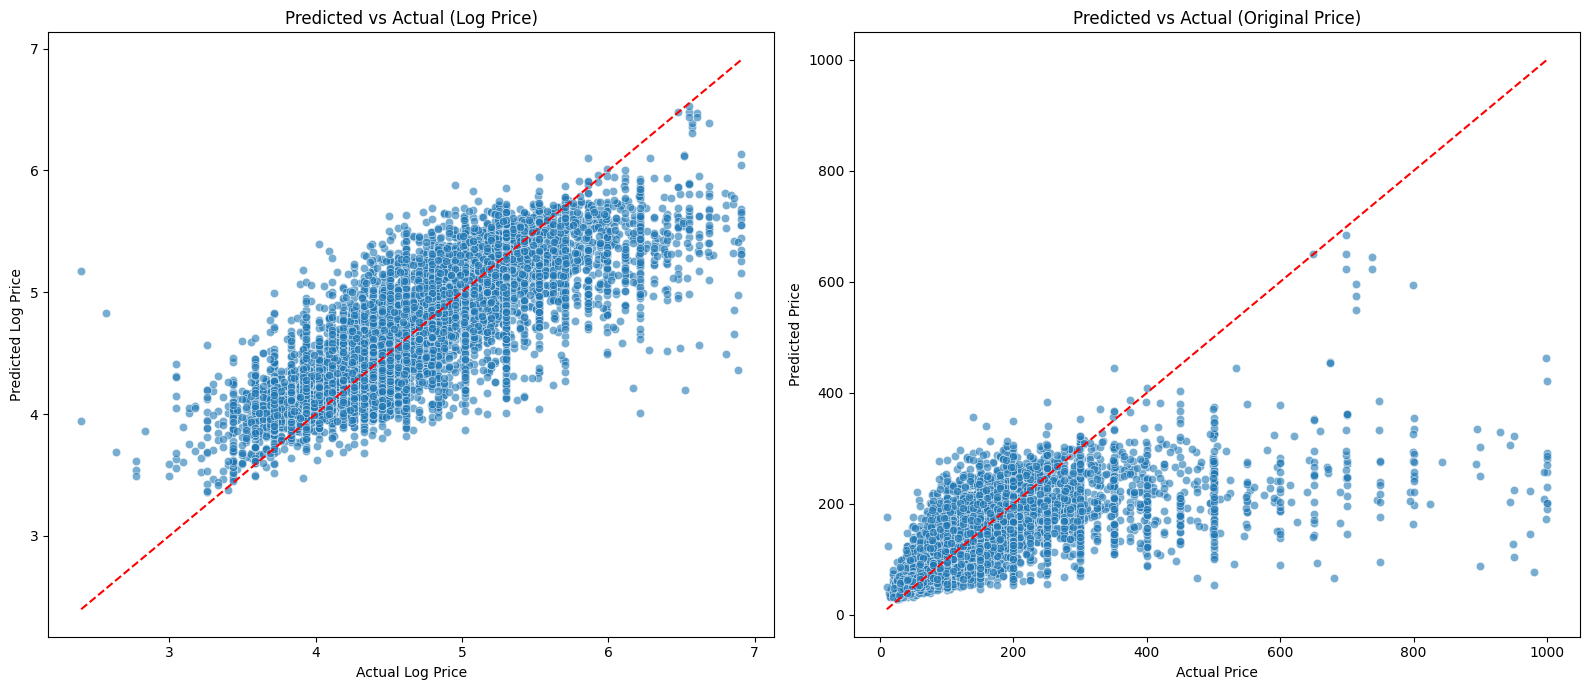

In [58]:
print("--- Diagnostic Plots: Predicted vs Actual ---")

plt.figure(figsize=(16, 7))

# Predicted vs Actual for Log Price
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_tuned_log, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicted vs Actual (Log Price)')
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')

# Predicted vs Actual for Original Price
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_original, y=y_pred_tuned_original, alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.title('Predicted vs Actual (Original Price)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.tight_layout()
plt.show()

--- Diagnostic Plots: Residuals Analysis ---


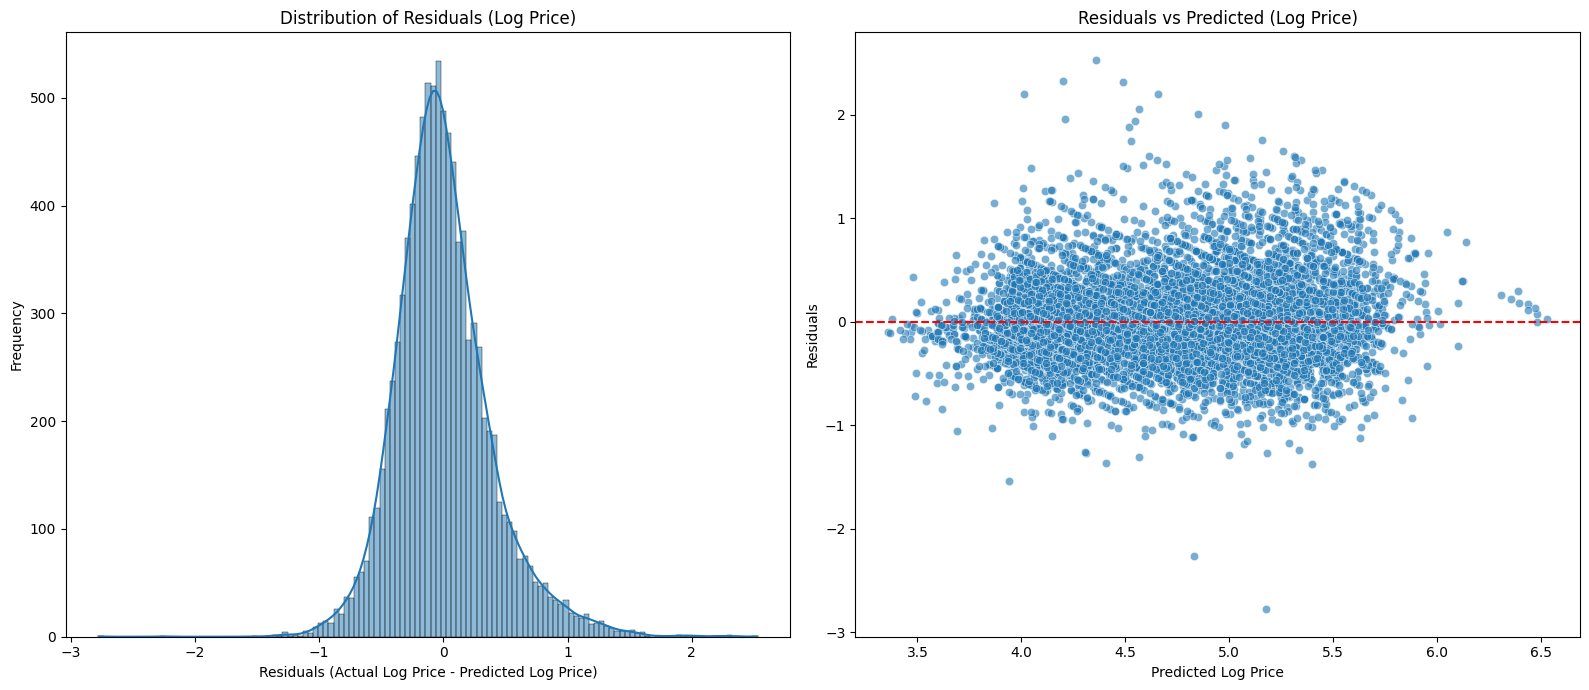

In [59]:
print("--- Diagnostic Plots: Residuals Analysis ---")

# Calculate residuals on log scale
residuals_log = y_test - y_pred_tuned_log

plt.figure(figsize=(16, 7))

# Distribution of Residuals (Log Price)
plt.subplot(1, 2, 1)
sns.histplot(residuals_log, kde=True)
plt.title('Distribution of Residuals (Log Price)')
plt.xlabel('Residuals (Actual Log Price - Predicted Log Price)')
plt.ylabel('Frequency')

# Residuals vs Predictions (Log Price)
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_tuned_log, y=residuals_log, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted (Log Price)')
plt.xlabel('Predicted Log Price')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

--- Diagnostic Plots: Feature Importance ---


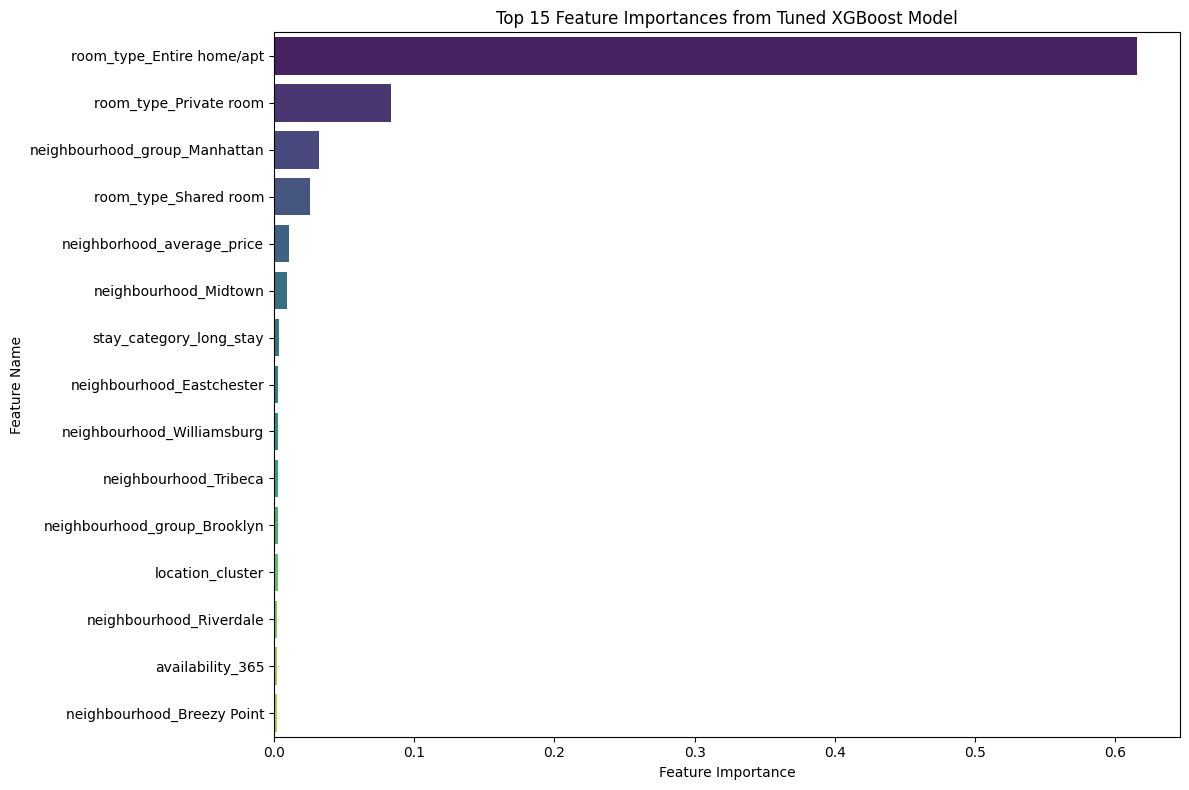

In [61]:
print("--- Diagnostic Plots: Feature Importance ---")

# Get feature importances from the tuned model
feature_importances = best_xgb_model.feature_importances_

# Create a pandas Series for easier manipulation
feature_names = X_preprocessed.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Display the top N features (e.g., top 15)
top_n = 15
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(top_n), palette='viridis', hue='feature', legend=False)
plt.title(f'Top {top_n} Feature Importances from Tuned XGBoost Model')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

# The diagnostic plots offer valuable insights into the performance and characteristics of the tuned XGBoost model:
-   **Predicted vs Actual Plots (Log Price and Original Price)**:
    -   **Log Price Plot**: The scatter plot of `Actual Log Price` vs `Predicted Log Price` shows a good alignment of points around the red diagonal line, especially in the mid-range of `log_price` values. This indicates that the model is generally performing well at predicting the log-transformed prices. There is some scattering, particularly at the higher and lower ends, suggesting that the model might struggle slightly with extreme values.
    -   **Original Price Plot**: When transformed back to the original price scale, the scatter plot of `Actual Price` vs `Predicted Price` also shows a generally good fit. However, the spread of points is more pronounced, especially for higher actual prices. This is expected due to the exponential nature of the `np.expm1` transformation; small errors in `log_price` can translate to larger absolute errors in `price`. The model captures the overall trend but has more difficulty with very high-priced listings, which tend to be underestimated.
    -   **Insights**: The model demonstrates strong predictive capabilities on the log scale, which translates reasonably well to the original scale. The concentration of points along the diagonal indicates that the model has learned the underlying patterns effectively. The increasing variance at higher price points suggests a limitation in accurately predicting very expensive listings.

-   **Residuals Analysis (Log Price)**:
    -   **Distribution of Residuals**: The histogram of residuals (`Actual Log Price - Predicted Log Price`) appears to be roughly normally distributed around zero, which is a desirable characteristic. This indicates that the model's errors are random and unbiased, suggesting that the model is not systematically over- or under-predicting across the range of `log_price` values.
    -   **Residuals vs Predicted Plot**: This scatter plot shows residuals on the y-axis against predicted `log_price` on the x-axis. Ideally, we want to see a random scatter of points around the horizontal line at y=0, indicating homoscedasticity (constant variance of errors) and no discernible pattern. The plot generally adheres to this, with residuals appearing somewhat uniformly distributed across the range of predicted `log_price` values. There is a slight fanning out at higher predicted `log_price` values, suggesting a minor degree of heteroscedasticity, meaning the model's errors might become slightly larger as the predicted price increases.
    -   **Insights**: The model's residuals are well-behaved on the log scale, confirming its robustness and lack of major systematic bias. The minor heteroscedasticity at higher predicted log prices is a common phenomenon in regression and might be further mitigated with more advanced modeling techniques or additional feature engineering, but it is not severe enough to significantly undermine the model's overall performance.

-   **Top Feature Importances from Tuned XGBoost Model**:
    -   The bar plot highlights the most influential features in predicting `log_price`. Unsurprisingly, features related to the **room type** (`room_type_Entire home/apt`, `room_type_Private room`, `room_type_Shared room`) are among the top predictors. This makes intuitive sense as entire homes/apartments generally command higher prices than private or shared rooms.
    -   **`neighborhood_average_price`** and **`neighbourhood_group_Manhattan`** are also highly important, reinforcing the EDA findings that location, especially at a granular neighborhood level and the borough of Manhattan, is a dominant factor in determining Airbnb prices. The `location_cluster` feature also contributes, indicating the value of geographical segmentation beyond traditional neighborhood boundaries.
    -   Other important features include **`latitude`** and **`longitude`**, further emphasizing the geographical influence, and **`calculated_host_listings_count`**, which might reflect the professionalism or scale of the host's operations, potentially correlating with pricing strategies. Features like `minimum_nights` and `availability_365` also have some importance, though less than location and room type.
    -   **Insights**: The model successfully identifies key drivers of Airbnb prices, with `room_type` and location-based features being paramount. This provides confidence that the model is learning meaningful relationships from the data. The engineered features (`neighborhood_average_price`, `location_cluster`) prove to be highly effective, validating the feature engineering process.

## Summary:

The task implicitly asked to build and evaluate an XGBoost model for predicting Airbnb prices, and to provide ML-engineer and business-oriented summaries.

**ML-Engineer Perspective on Model Performance:**
The tuned XGBoost model achieved an R-squared of 0.6588 on the log-transformed price scale, with an RMSE of 0.3899. On the original price scale, the model yielded a Mean Absolute Error (MAE) of 44.70, an RMSE of 87.30, and an R-squared of 0.4537. This indicates that on average, the model's predictions are within approximately 45 of the actual price, and it explains about 45% of the variance in original prices, which is reasonable for complex real-world pricing data.

**Business Interpretation of Key Price Drivers:**
The most influential features in driving Airbnb pricing in NYC are:
1.  Room Type: Listings categorized as 'Entire home/apt' command significantly higher prices, while 'Private room' and 'Shared room' are less expensive.
2.  Geographical Location: Manhattan (especially specific neighborhoods and clusters identified by latitude/longitude) is a primary driver of higher prices, with the 'neighborhood_average_price' and 'neighbourhood_group_Manhattan' being top indicators.
3.  Host Activity: The 'calculated_host_listings_count' (number of listings a host manages) also plays a moderately important role.
4.  Reviews and Availability: 'reviews_per_month' and 'availability_365' also contribute, suggesting active and available listings can influence pricing.

### Data Analysis Key Findings
*   The initial dataset contained 48,895 listings with 16 columns. Notable missing values were found in 'name', 'host_name', 'last_review', and 'reviews_per_month'.
*   Initial 'price' data was highly skewed, ranging from 0 to 10,000, with an average price of 152.
*   Data cleaning involved removing listings with prices less than or equal to 0 or greater than 1,000, reducing the dataset to 48,645 entries. A 'log_price' feature was created using np.log1p to normalize the price distribution.
*   The Exploratory Data Analysis (EDA) confirmed that the 'price' distribution was highly right-skewed, while 'log_price' exhibited a more normal distribution, suitable for modeling.
*   EDA also revealed significant price disparities across neighbourhood_groups, with Manhattan having the highest average prices, followed by Brooklyn. Geographical plots showed clusters of higher-priced listings predominantly in Manhattan.
*   Feature engineering successfully created four new features: neighborhood_average_price, location_cluster (via KMeans on latitude/longitude), has_reviews, and stay_category (derived from minimum_nights).
*   The preprocessing step involved imputing missing numerical values with the median and categorical values with the mode. One-hot encoding converted 4 categorical features into 232 new binary features, expanding the feature set to 243 columns.
*   The dataset was split into training (80%, 38,916 samples) and testing (20%, 9,729 samples) sets.
*   A baseline XGBoost model achieved an R-squared of 0.6517 (log scale) and an MAE of 45.26 (original scale).
*   Hyperparameter tuning using RandomizedSearchCV yielded improved performance for the tuned XGBoost model, achieving an R-squared of 0.6588 (log scale) and an MAE of 44.70 (original scale), a slight improvement over the baseline.
*   Model diagnostics showed a good fit between predicted and actual log prices. Residuals were mostly normally distributed around zero, indicating low bias. However, the model tended to underpredict very high prices, and some heteroscedasticity was observed with larger errors for higher predicted prices.
*   Feature importance analysis confirmed that 'room_type', geographical features ('neighbourhood_group_Manhattan', 'neighborhood_average_price', 'latitude', 'longitude', 'location_cluster'), and 'calculated_host_listings_count' were the most influential predictors of price.